# Assignment 8

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

------

## Question 1

### Slicing into RGB 

In [2]:
img = cv2.imread('images/input1.PNG')
imgB, imgG, imgR = cv2.split(img)

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
hsvH, hsvS, hsvV = cv2.split(hsv)

### Functions

In [3]:
def HE(new_img):
    mapping = {}

    for i in range(256):
        mapping[i] = 0

    for i in range(new_img.shape[0]):
        for j in range(new_img.shape[1]):
            mapping[new_img[i][j]] += 1

    pixel_count = new_img.shape[0]*new_img.shape[1]

    temp = {}
    for i in range(256):
        temp[i] = 0

    cum_sum = 0
    for i,j in mapping.items():
        cum_sum += j/pixel_count
        temp[i] = int((cum_sum*255)+0.5)

    HE_img = np.zeros((new_img.shape[0], new_img.shape[1]), dtype=np.uint8)

    for i in range(new_img.shape[0]):
        for j in range(new_img.shape[1]):
            HE_img[i][j] = temp[new_img[i][j]]
            
    return HE_img

### HE on the R, G, B Slices and the I slice

In [4]:
# HE on the RGB slices of the RGB image
HE_imgB = HE(imgB)
HE_imgG = HE(imgG)
HE_imgR = HE(imgR)

# HE on the I slice of the HSI image
HE_hsvV = HE(hsvV)

### Initial Results 

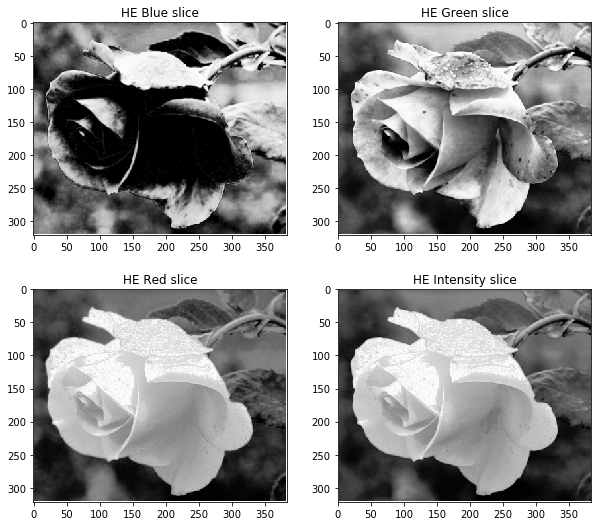

In [5]:
# Joining the RGB slices
HE_img = np.dstack((HE_imgB, HE_imgG, HE_imgR))

# joining the I slice
HE_hsv = np.dstack((hsvH, hsvS, HE_hsvV))

# cv2.imwrite('results/HE_img1.png', HE_img)

X, Y = 2, 2
fig = plt.figure(figsize=(10, 9))

fig.add_subplot(X,Y,1)
plt.title('HE Blue slice')
plt.imshow(HE_imgB, cmap='gray')

fig.add_subplot(X,Y,2)
plt.title('HE Green slice')
plt.imshow(HE_imgG, cmap='gray')

fig.add_subplot(X,Y,3)
plt.title('HE Red slice')
plt.imshow(HE_imgR, cmap='gray')

fig.add_subplot(X,Y,4)
plt.title('HE Intensity slice')
plt.imshow(HE_hsvV, cmap='gray')

plt.show()

### Final Results

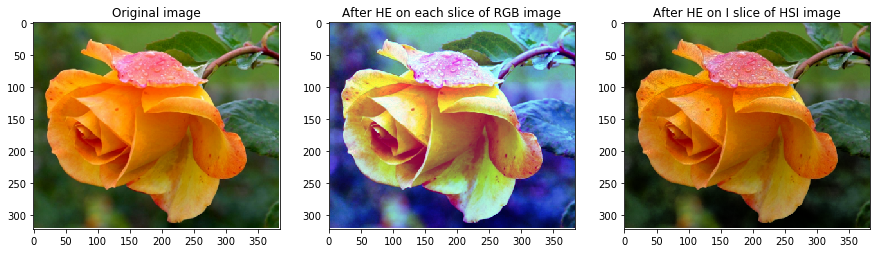

In [6]:
fig = plt.figure(figsize=(15, 15))

fig.add_subplot(1,3,1)
plt.title('Original image')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

fig.add_subplot(1,3,2)
plt.title('After HE on each slice of RGB image')
plt.imshow(cv2.cvtColor(HE_img, cv2.COLOR_BGR2RGB))

fig.add_subplot(1,3,3)
plt.title('After HE on I slice of HSI image')
plt.imshow(cv2.cvtColor(HE_hsv, cv2.COLOR_HSV2RGB))

plt.show()

# cv2.imwrite('results/HE_HSV_img1.png', HE_HSV_img)

------

## Question 2

### Load the images and initialize the Structural Elements

In [7]:
img = cv2.VideoCapture('images/input2.gif')
ret,frame = img.read()
img2 = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
_, img2 = cv2.threshold(img2,150,255,cv2.THRESH_BINARY)
img3 = cv2.imread('images/input3.bmp', 0)
img4 = cv2.imread('images/input4.bmp', 0)

square = np.ones((5, 5))
diamond = np.array([[0, 0, 1, 0, 0],
                    [0, 1, 1, 1, 0],
                    [1, 1, 1 ,1, 1],
                    [0, 1, 1, 1, 0],
                    [0, 0, 1, 0, 0]])
octagon = np.array([[0, 1, 1, 1, 0],
                    [1, 1, 1, 1, 1],
                    [1, 1, 1 ,1, 1],
                    [1, 1, 1, 1, 1],
                    [0, 1, 1, 1, 0]])

pad_size = 2

### Functions

In [8]:
def padding(A, val, S):
    pad_size = S.shape[0] // 2
    padded_A = np.ones((A.shape[0] + 2*pad_size, A.shape[1] + 2*pad_size))
    padded_A *= val
    padded_A[pad_size:-pad_size, pad_size:-pad_size] = A
    return padded_A


def Erosion(pad_A, S):
    pad_size = S.shape[0] // 2
    pos = np.where(S == 1)
        
    E = np.zeros(pad_A.shape, dtype=np.uint8)
    for i in range(pad_size, pad_A.shape[0]-pad_size):
        for j in range(pad_size, pad_A.shape[1]-pad_size):
            slice_ = np.copy(pad_A[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1])                  
            flag = 0
            for k in range(len(pos[0])):
                if slice_[pos[0][k], pos[1][k]] == 0: 
                    flag = 1
                    break
            
            if flag == 1:
                E[i, j] = 0
            else : 
                E[i,j] = 255
    
    return E


def Dilation(pad_A, S):
    pad_size = S.shape[0] // 2
    pos = np.where(S == 1)
        
    D = np.zeros(pad_A.shape, dtype=np.uint8)
    for i in range(pad_size, pad_A.shape[0]-pad_size):
        for j in range(pad_size, pad_A.shape[1]-pad_size):
            slice_ = np.copy(pad_A[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1])                  
            flag = 0
            for k in range(len(pos[0])):
                if slice_[pos[0][k], pos[1][k]] == 255: 
                    flag = 1
                    break
            
            if flag == 1:
                D[i, j] = 255
            else : 
                D[i,j] = 0
    
    return D

def Closing(A, S):
    D = Dilation(A, S)
    E = Erosion(D, S)
    
    return E

def Opening(A, S):
    E = Erosion(A, S)
    D = Dilation(E, S)
    
    return D

### Final Results

#### NOTE : you can change the SE from square to diamond or octagon

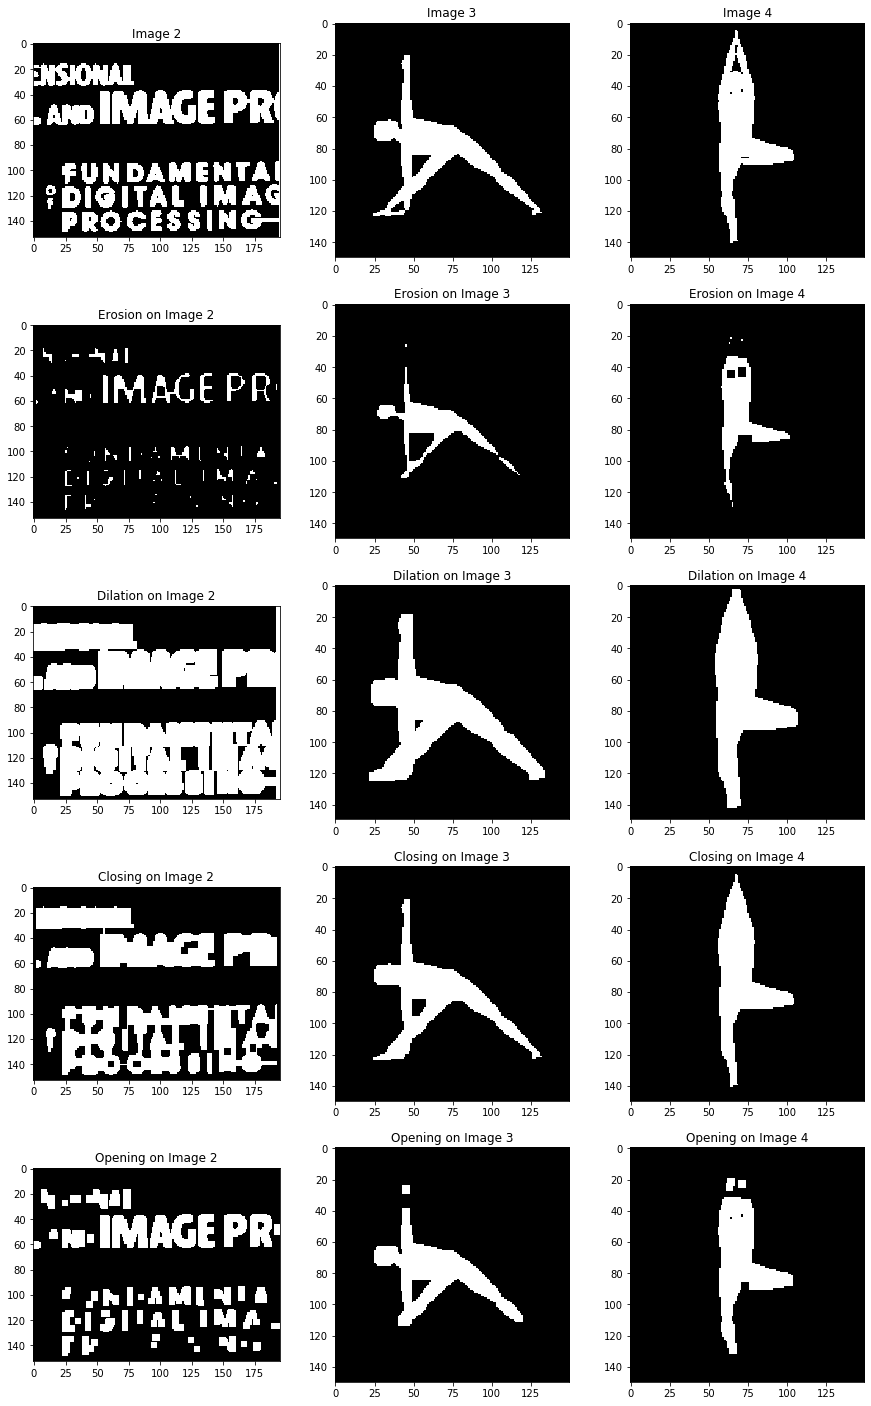

In [9]:
images = [img2, img3, img4]
fig = plt.figure(figsize=(15, 25))

for i in range(3):
    fig.add_subplot(5,3,i+1)
    plt.title('Image ' + str(2+i))
    plt.imshow(images[i], cmap='gray')
    
    pad_img = padding(images[i], 0, square)
    E = Erosion(pad_img, square)
    fig.add_subplot(5,3,i+4)
    plt.title('Erosion on Image ' + str(2+i))
    plt.imshow(E[pad_size:-pad_size, pad_size:-pad_size], cmap='gray')
    
    
    D = Dilation(pad_img, square)
    fig.add_subplot(5,3,i+7)
    plt.title('Dilation on Image ' + str(2+i))
    plt.imshow(D[pad_size:-pad_size, pad_size:-pad_size], cmap='gray')
    
    
    C = Closing(pad_img, square)
    fig.add_subplot(5,3,i+10)
    plt.title('Closing on Image ' + str(2+i))
    plt.imshow(C[pad_size:-pad_size, pad_size:-pad_size], cmap='gray')

    
    O = Opening(pad_img, square)
    fig.add_subplot(5,3,i+13)
    plt.title('Opening on Image ' + str(2+i))
    plt.imshow(O[pad_size:-pad_size, pad_size:-pad_size], cmap='gray')

plt.show()

------

## Q3

### Functions

In [10]:
def HAM(A, pad_A, S):
    inv_A = cv2.bitwise_not(A)
        
    dia = np.array([[0,1,0],
                    [1,1,1],
                    [0,1,0]])
    
    S_pad = padding(S, 0, dia)
    W = 1*(Dilation(S_pad*255, dia)[1:-1, 1:-1] == 255)
    
    W_S = W - S
    
    pad_inv_A = padding(inv_A, 0, S)
    
    mat1 = Erosion(pad_A, S)
    mat2 = Erosion(pad_inv_A, W_S)
    
    ham = np.bitwise_and(mat1==255, mat2==255)
    
    return mat1, mat2, ham

### Calling HAM

In [11]:
img5 = cv2.imread('images/input5.bmp', 0)

S1 = np.zeros((13,13), dtype=np.uint8)
S1[1:-1,1:-1] = 1

pad_img5 = padding(img5, 0, S1)

mat1, mat2, ham = HAM(img5, pad_img5, S1)

### Final Results

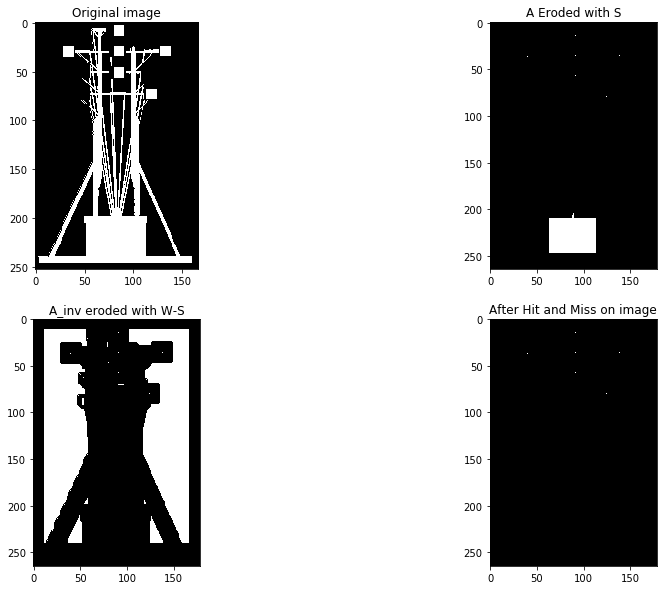

In [12]:
fig = plt.figure(figsize=(15, 10))

fig.add_subplot(2,2,1)
plt.title('Original image')
plt.imshow(img5, cmap='gray')

fig.add_subplot(2,2,2)
plt.title('A Eroded with S')
plt.imshow(mat1, cmap='gray')

fig.add_subplot(2,2,3)
plt.title('A_inv eroded with W-S')
plt.imshow(mat2, cmap='gray')

fig.add_subplot(2,2,4)
plt.title('After Hit and Miss on image')
plt.imshow(ham, cmap='gray')

plt.show()

------

## Q4 - WIP

### Functions

In [13]:
def Thick(A, S):
    pad_A = padding(A, 0, S)
    ham_A = HAM(pad_A, S)
    thick = (pad_A + ham_A)
    
    return thick
    
def Thin(pad_A, S):
    ham_A = HAM(pad_A, S)
    thin = np.multiply(pad_A, cv2.bitwise_not(ham_A))

    return thin

### Process

In [14]:
img3 = cv2.imread('images/input3.bmp', 0)
img4 = cv2.imread('images/input4.bmp', 0)

S1 = np.array([[0, 0, 0],
               [-1, 1, -1],
               [1, 1, 1]])

S2 = np.array([[-1, 0, 0],
              [1, 1, 0],
              [1, 1, -1]])

np.rot90(S1, 1), np.rot90(S2, 1)

(array([[ 0, -1,  1],
        [ 0,  1,  1],
        [ 0, -1,  1]]),
 array([[ 0,  0, -1],
        [ 0,  1,  1],
        [-1,  1,  1]]))

In [15]:
# images = []
# fig = plt.figure(figsize=(15, 20))

# fig.add_subplot(5,1,1)
# plt.title('Original image')
# plt.imshow(img3, cmap='gray')

# test = np.copy(img3)
# for i in range(1, 5):
#     test_pad = padding(test, 0, S1)
#     print(test_pad.shape)
#     thin = Thin(test_pad, S1, S2)
#     fig.add_subplot(5,1,1+i)
#     plt.title('Thinning '+ str(i))
#     plt.imshow(thin, cmap='gray')
#     test = np.copy(thin)
#     S1, S2 = np.rot90(S1, 1), np.rot90(S2, 1)

# plt.show()

### Final Results

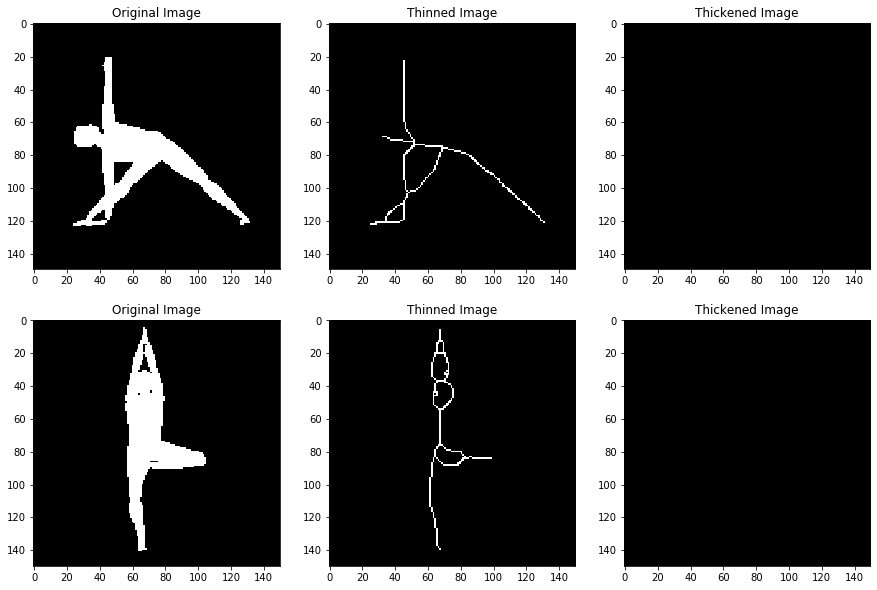

In [16]:
# Plotting
fig = plt.figure(figsize=(15, 10))

thinned = cv2.ximgproc.thinning(img3)
thicked = cv2.ximgproc.thinning(np.bitwise_not(img3==255).astype(np.uint8))

fig.add_subplot(2,3,1)
plt.title('Original Image')
plt.imshow(img3, cmap='gray')

fig.add_subplot(2,3,2)
plt.title('Thinned Image')
plt.imshow(thinned, cmap='gray')

fig.add_subplot(2,3,3)
plt.title('Thickened Image')
plt.imshow(thicked, cmap='gray')

thinned = cv2.ximgproc.thinning(img4)
thicked = cv2.ximgproc.thinning(np.bitwise_not(img4==255).astype(np.uint8))

fig.add_subplot(2,3,4)
plt.title('Original Image')
plt.imshow(img4, cmap='gray')

fig.add_subplot(2,3,5)
plt.title('Thinned Image')
plt.imshow(thinned, cmap='gray')

fig.add_subplot(2,3,6)
plt.title('Thickened Image')
plt.imshow(thicked, cmap='gray')

plt.show()

------
## Q5

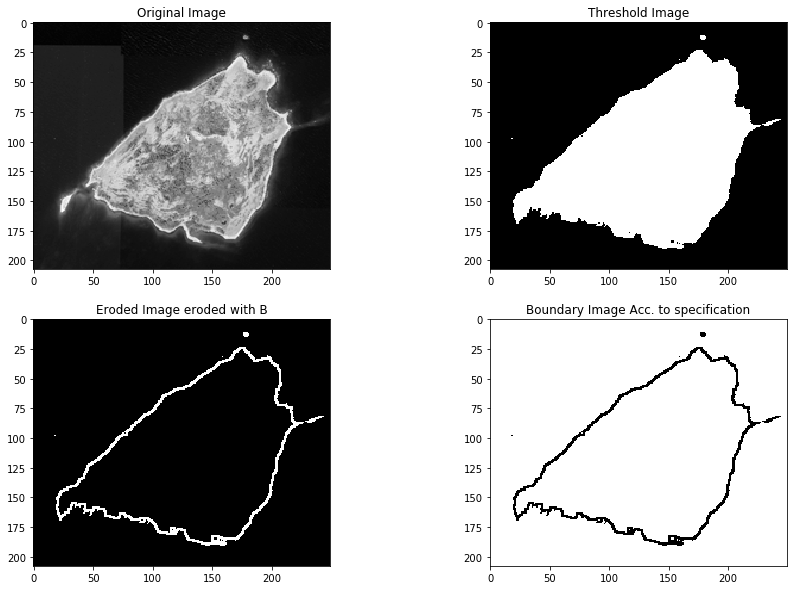

In [18]:
img6 = cv2.imread('images/input6.bmp', 0)
B = np.ones((5,5), dtype=np.uint8)

_, T = cv2.threshold(img6,75,255,cv2.THRESH_BINARY)

ero = Erosion(T, B)

fin = T - ero

# Plotting
fig = plt.figure(figsize=(15, 10))

fig.add_subplot(2,2,1)
plt.title('Original Image')
plt.imshow(img6, cmap='gray')

fig.add_subplot(2,2,2)
plt.title('Threshold Image')
plt.imshow(T, cmap='gray')

fig.add_subplot(2,2,3)
plt.title('Eroded Image eroded with B')
plt.imshow(fin, cmap='gray')

fig.add_subplot(2,2,4)
plt.title('Boundary Image Acc. to specification')
plt.imshow(cv2.bitwise_not(fin), cmap='gray')

plt.show()

------
## Q6

(51522,)


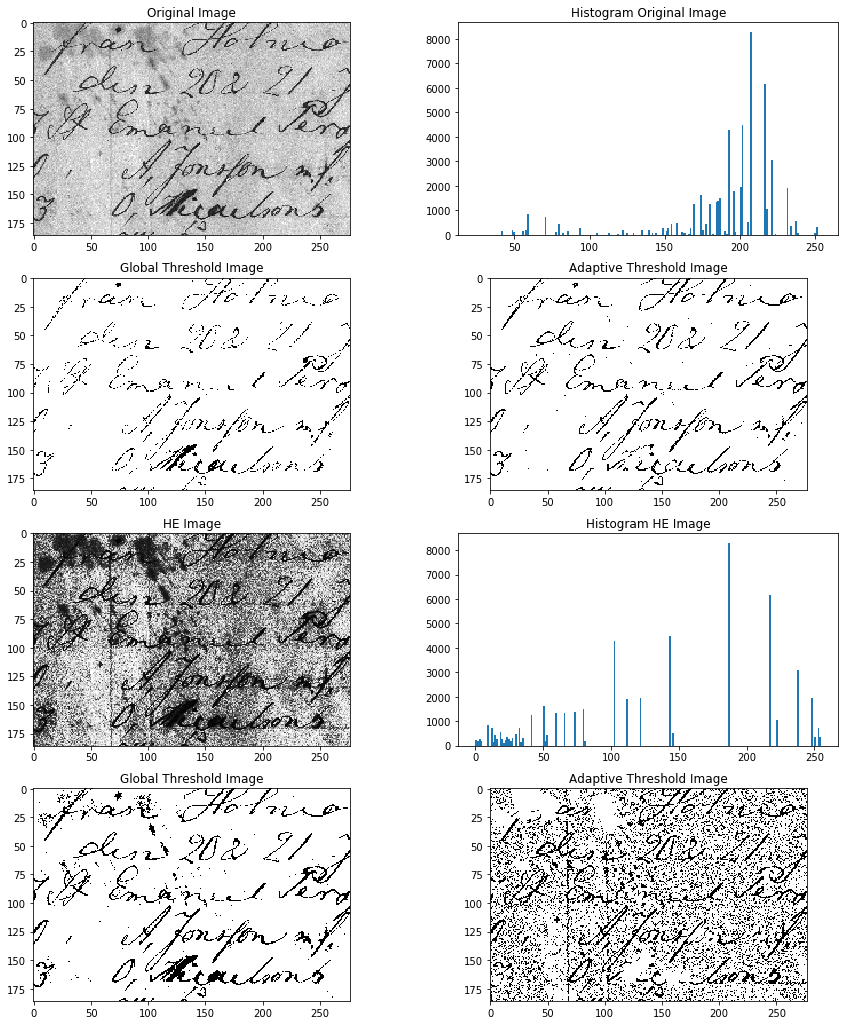

In [19]:
img7 = cv2.imread('images/input7.bmp', 0)
_, T = cv2.threshold(img7, 75, 255, cv2.THRESH_BINARY)
AT = cv2.adaptiveThreshold(img7,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,15, 60)

HE_img = HE(img7)
_, HE_T = cv2.threshold(HE_img, 25, 255, cv2.THRESH_BINARY)
HE_AT = cv2.adaptiveThreshold(HE_img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,15, 50)

print(img7.flatten().shape)

# Plotting
fig = plt.figure(figsize=(15,18))

fig.add_subplot(4,2,1)
plt.imshow(img7, cmap='gray')
plt.title('Original Image')
fig.add_subplot(4,2,2)
plt.hist(img7.flatten(), bins=200)
plt.title('Histogram Original Image')


fig.add_subplot(4,2,3)
plt.imshow(T, cmap='gray')
plt.title('Global Threshold Image')

fig.add_subplot(4,2,4)
plt.imshow(AT, cmap='gray')
plt.title('Adaptive Threshold Image')


fig.add_subplot(4,2,5)
plt.imshow(HE_img, cmap='gray')
plt.title('HE Image')
fig.add_subplot(4,2,6)
plt.hist(HE_img.flatten(), bins=200)
plt.title('Histogram HE Image')

fig.add_subplot(4,2,7)
plt.imshow(HE_T,  cmap='gray')
plt.title('Global Threshold Image')

fig.add_subplot(4,2,8)
plt.imshow(HE_AT, cmap='gray')
plt.title('Adaptive Threshold Image')

plt.show()